# IMPORTS


In [1]:
import numpy as np
import cv2 as cv

import torch
from torchvision import datasets, transforms

import utils.loader as utl


from utils.loader import Loader

CHECK FOR GPU PROCESSING AVAILABILITY

In [21]:
if torch.cuda.is_available():
    print("CUDA is available")
    print("Devices:")
    print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
else:
    print("CUDA is not available")

CUDA is available
Devices:
['NVIDIA GeForce RTX 4050 Laptop GPU']


### COUNTS AND RATIO

In [3]:
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

val_loader: Loader = utl.Loader(VAL_PATH, transform=transform)

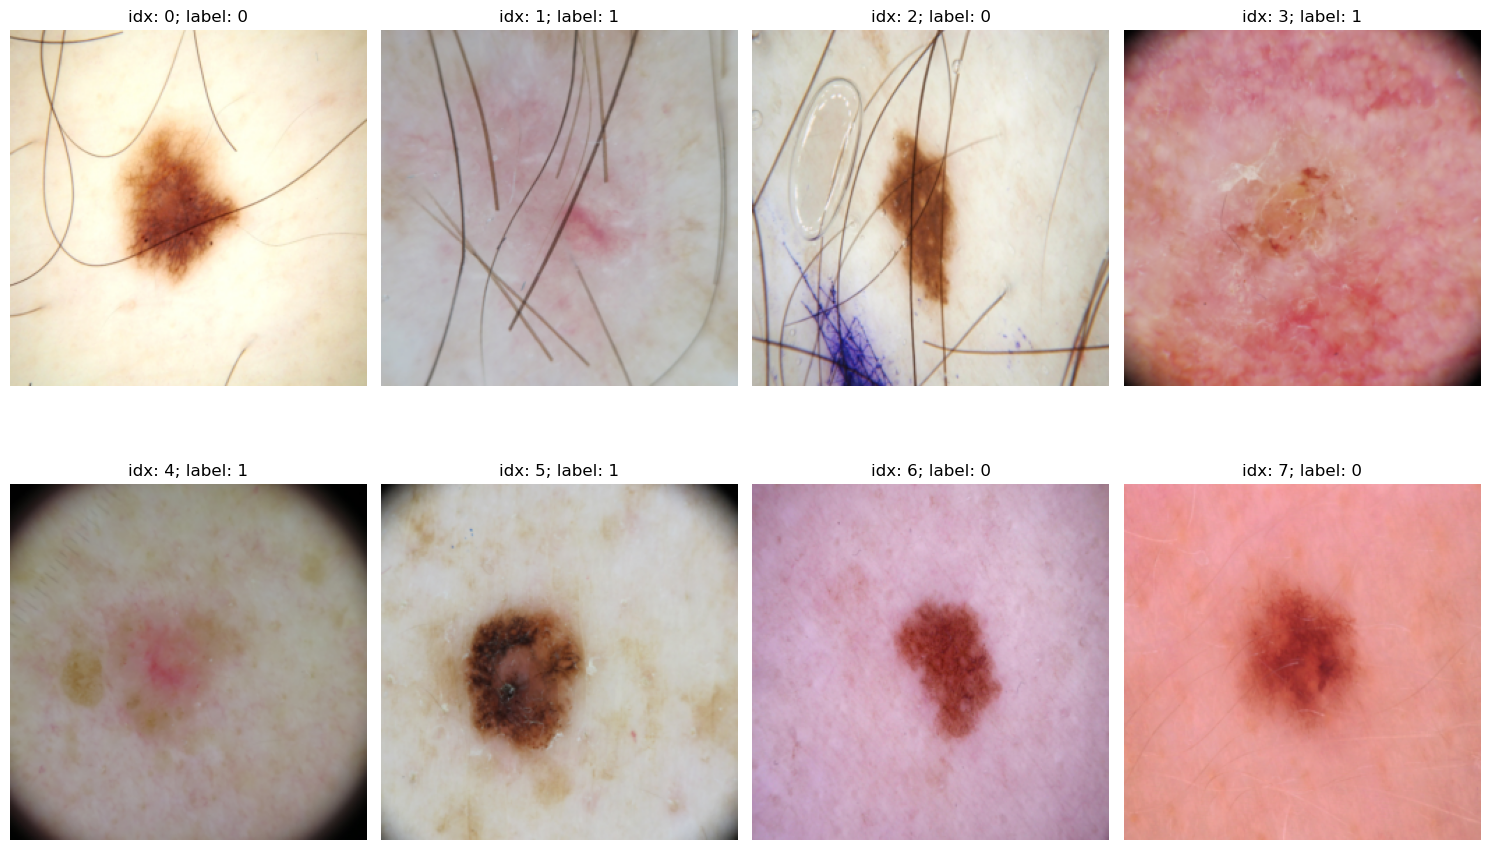

In [4]:
val_loader.show_images(8, False)

In [5]:
import os
NEV_PATH = os.path.join(VAL_PATH, "nevus")
OTH_PATH = (os.path.join(VAL_PATH, "others"))

print(f"NEVUS: {len(os.listdir(NEV_PATH))}")
print(f"OTHERS: {len(os.listdir(OTH_PATH))}")
print(f"Ratio Nevus/Others: {len(os.listdir(NEV_PATH)) / len(os.listdir(OTH_PATH))}")

NEVUS: 1931
OTHERS: 1865
Ratio Nevus/Others: 1.0353887399463806


### SHAPES

In [6]:
def count_image_dimensions(dataloader):
    dimension_count = {}

    # Iterate through the DataLoader
    for batch in dataloader:
        # Assuming the images are the first element of the batch (usually batch[0] in a tuple)
        images = batch[0]
        
        # Iterate through each image in the batch
        for img in images:
            # Get the image dimensions (height, width), assuming the image is in CHW format
            _, height, width = img.shape
            
            # Use the dimensions as a key in the dictionary
            dimensions = (height, width)
            
            # Count the occurrences of each dimension
            if dimensions in dimension_count:
                dimension_count[dimensions] += 1
            else:
                dimension_count[dimensions] = 1

    return dimension_count

# Example usage
# Assuming you have a PyTorch DataLoader `my_dataloader`
# dimension_count = count_image_dimensions(my_dataloader)
# print(dimension_count)


In [7]:
import logging

RUN = 0
if RUN:    
    nev_dimension_count = {}
    oth_dimension_count = {}
    
    for idx, file in enumerate(os.listdir(NEV_PATH)):
    
        if os.path.splitext(file)[1] != ".jpg":
            logging.warning(f"File {file} at index {idx} is not a .jpeg")
            continue
        img = cv.imread(os.path.join(NEV_PATH, file), cv.IMREAD_UNCHANGED)
        
        shape = str(img.shape )   
        
        if shape not in nev_dimension_count:
            nev_dimension_count[shape] = 1
        
        nev_dimension_count[shape] += 1
    
    
    for idx, file in enumerate(os.listdir(OTH_PATH)):
        if os.path.splitext(file)[1] != ".jpg":
            logging.warning(f"File {file} at index {idx} is not a .jpeg")
            continue
        
        img = cv.imread(os.path.join(OTH_PATH, file), cv.IMREAD_UNCHANGED)
        
        shape = str(img.shape)   
        
        if shape not in oth_dimension_count:
            oth_dimension_count[shape] = 1
        
        oth_dimension_count[shape] += 1
    
    for i in nev_dimension_count:
        print(i)
        
    for i in oth_dimension_count:
        print(i)

DIMS

## LOADERS

In [8]:
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

## Vanilla

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

val_loader_padded: Loader = utl.Loader(VAL_PATH, transform=transform)

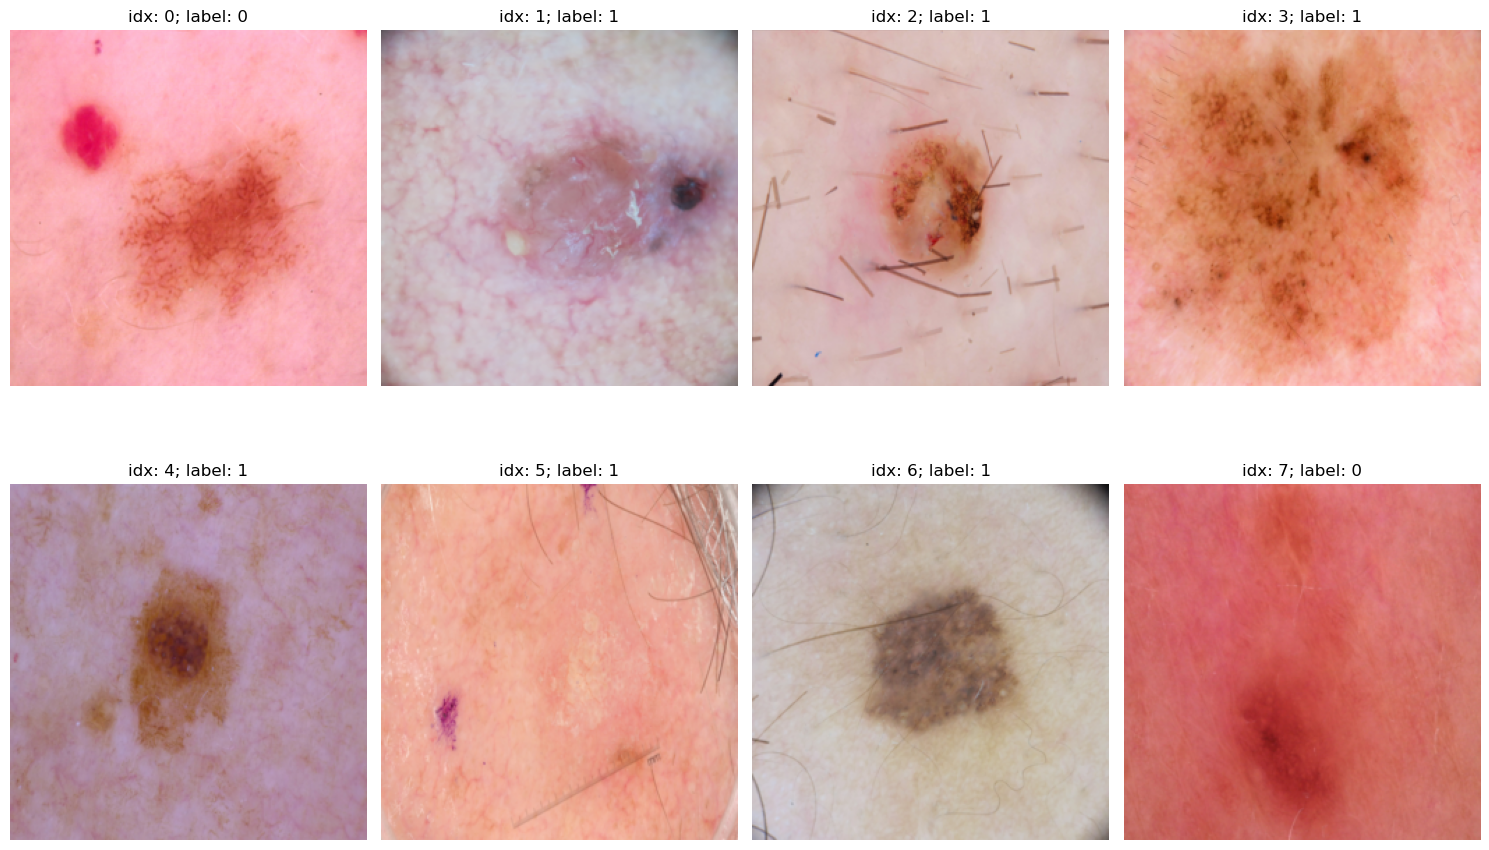

In [10]:
# val_loader.show_images(8)
val_loader_padded.show_images(8)

## Factory

In [11]:
from utils.loader import FactoryLoader
from utils.preprocessing import PreprocessingFactory

# Use the PreprocessingFactory to define the pipeline
factory = PreprocessingFactory()
factory.pad2square(fill=np.nan)
factory.normalize2float()
factory.resize((256,256))
factory.gaussian_smoothing(kernel_size=3)
# factory.normalize2float()
# factory.hair_removal()
# factory.add_normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

factory.get_steps()

# Initialize Loader with the factory
ldr = FactoryLoader(path=VAL_PATH, batch_size=32, factory=factory)

# Display some images with the applied preprocessing
ldr.show_images(num_images=8, randomize=False)

# Features

## Brute/hardcoded

In [12]:
from torch.utils.data import DataLoader

RUN = 0
if RUN:
    # Feature extraction function
    def extract_features(loader: DataLoader):
        feature_vectors = []
    
        for batch in loader:
            images, labels = batch
    
            # Iterate through images in the batch
            for image in images:
                image_np = image.numpy()  # Convert tensor to NumPy
    
                # Basic feature extraction
                mean = np.mean(image_np, axis=(1, 2))  # Mean per channel (C, H, W)
                std = np.std(image_np, axis=(1, 2))    # Std per channel (C, H, W)
                var = np.var(image_np, axis=(1, 2))    # Variance per channel (C, H, W)
    
                # Concatenate features into a single feature vector
                feature_vector = np.concatenate([mean, std, var])
    
                # Add to feature vector list
                feature_vectors.append(feature_vector)
    
        # Convert list of feature vectors to a NumPy array
        feature_matrix = np.array(feature_vectors)
    
        return feature_matrix
    
    # Extract features
    feature_matrix = extract_features(ldr.get_loader())
    
    print("Feature matrix shape:", feature_matrix.shape)  # Should be (num_images, num_features)
    print("Example feature vector for one image:", feature_matrix[0])

## Modular

In [13]:
from utils.feature_extraction import *

# Initialize the FactoryLoader
factory = PreprocessingFactory()
factory.normalize2float()
factory.pad2square(fill=np.nan)
factory.resize((256,256))
factory_loader = FactoryLoader(path=VAL_PATH, batch_size=24, factory=factory, percentage=20)

# Create the feature extraction pipeline strategy and add desired features
pipeline = FeatureExtractionStrategy()
pipeline.add_extractor(MeanExtractor())  # Add mean feature
pipeline.add_extractor(StdExtractor())   # Add standard deviation feature
pipeline.add_extractor(VarExtractor())   # Add variance feature
pipeline.add_extractor(MaxExtractor())   # Add maximum pixel value feature

# Extract features using the pipeline
feature_matrix = extract_features(ldr.get_loader(), pipeline)

print("Feature matrix shape:", feature_matrix.shape)  # Shape: (num_images, num_features)
print("Example feature vector for one image:", feature_matrix[0])
print("Example feature dict for one image:", pipeline.get_feature_names())

Feature matrix shape: (3796, 12)
Example feature vector for one image: [0.7094461  0.68761015 0.67680025 0.12050081 0.13188037 0.13688551
 0.01452045 0.01739243 0.01873764 0.81807595 0.8168505  0.8292892 ]
Example feature dict for one image: ['mean_channel_0', 'mean_channel_1', 'mean_channel_2', 'std_channel_0', 'std_channel_1', 'std_channel_2', 'var_channel_0', 'var_channel_1', 'var_channel_2', 'max_channel_0', 'max_channel_1', 'max_channel_2']


classes
transformation steps
{'01_norm': {}, 'pad2square': {'fill': nan}, 'resize': {'size': (256, 256)}}


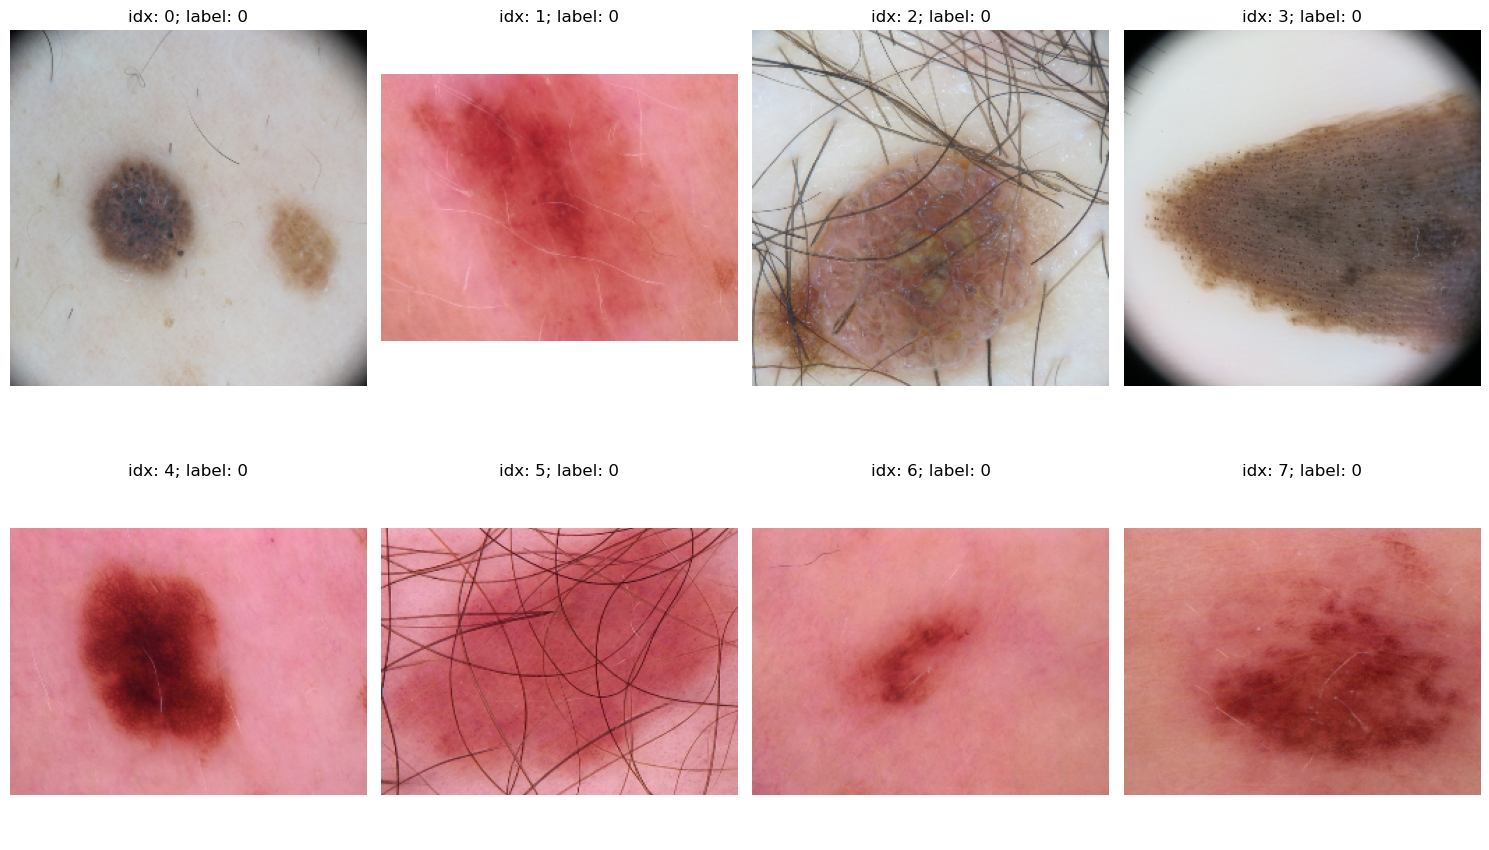

In [14]:
print("classes")
factory_loader.get_classes()
print("transformation steps")
print(factory_loader.get_transformation_steps())
factory_loader.show_images()


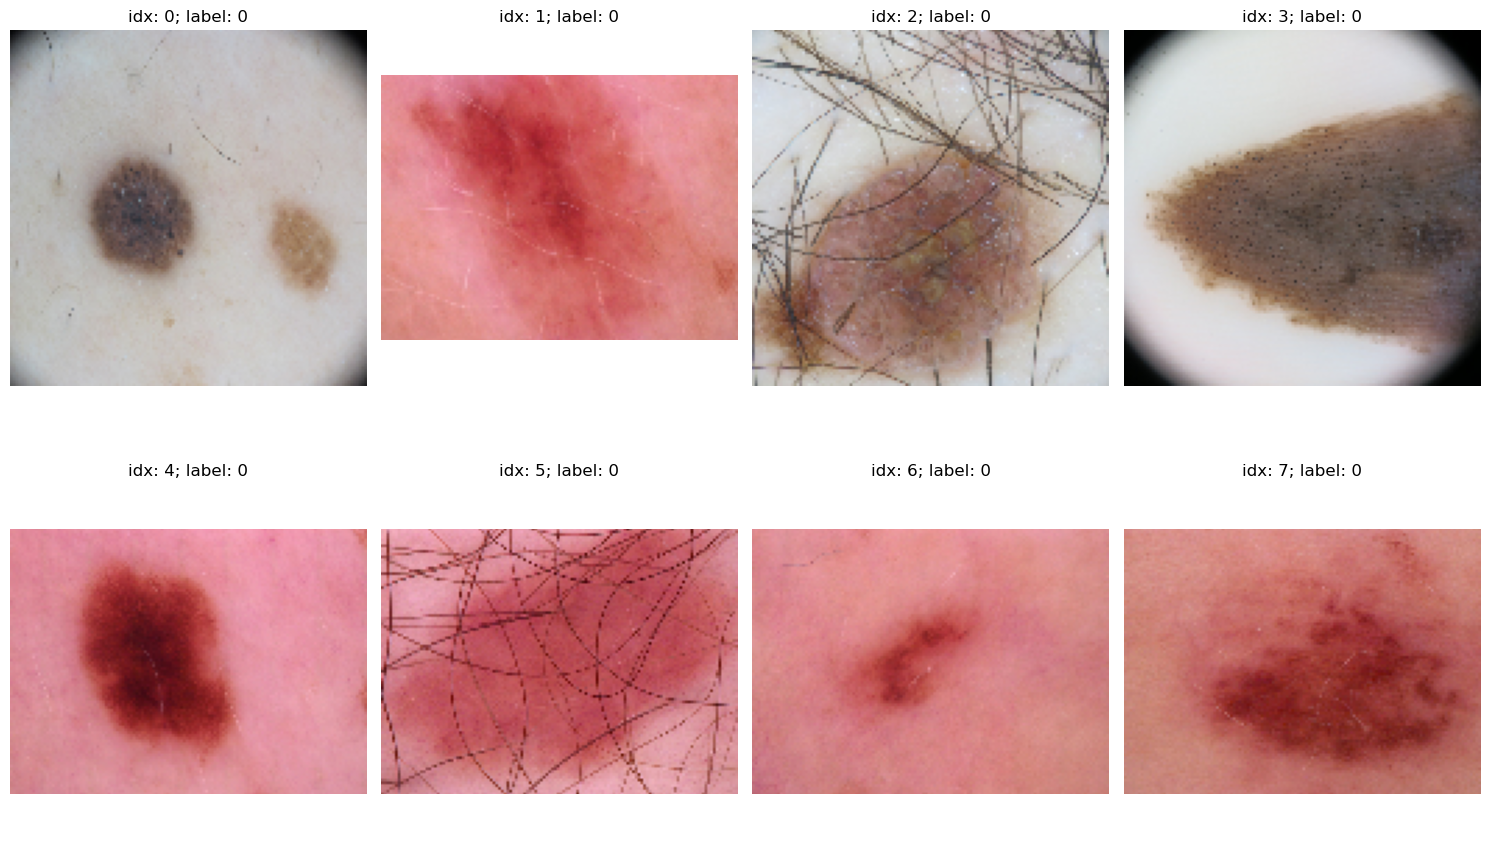

{'01_norm': {}, 'pad2square': {'fill': nan}, 'resize': {'size': (128, 128)}}
189


In [20]:
# Initialize the FactoryLoader
factory = PreprocessingFactory()
factory.normalize2float()
factory.pad2square(fill=np.nan)
factory.resize((128,128))
factory_loader = FactoryLoader(path=VAL_PATH, batch_size=24, factory=factory, percentage=5)
factory_loader.show_images()
print(factory_loader.get_transformation_steps())
print(factory_loader.get_size())
